In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [31]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'])

In [32]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [33]:
sales_b.shape

(60, 4)

In [34]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Month-Year         60 non-null     datetime64[ns]
 1   Sales              60 non-null     int64         
 2   Market Size        60 non-null     int64         
 3   Marketing Expense  60 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.0 KB


In [35]:
sales_b['Sales'].sum()

70016882

In [36]:
sales_b = sales_b.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_b.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,494357,2738080,177316
1,2019-02-01,837207,4637013,300290
2,2019-03-01,1278271,7079920,458491
3,2019-04-01,675985,3744057,242463
4,2019-05-01,757687,4196578,271768


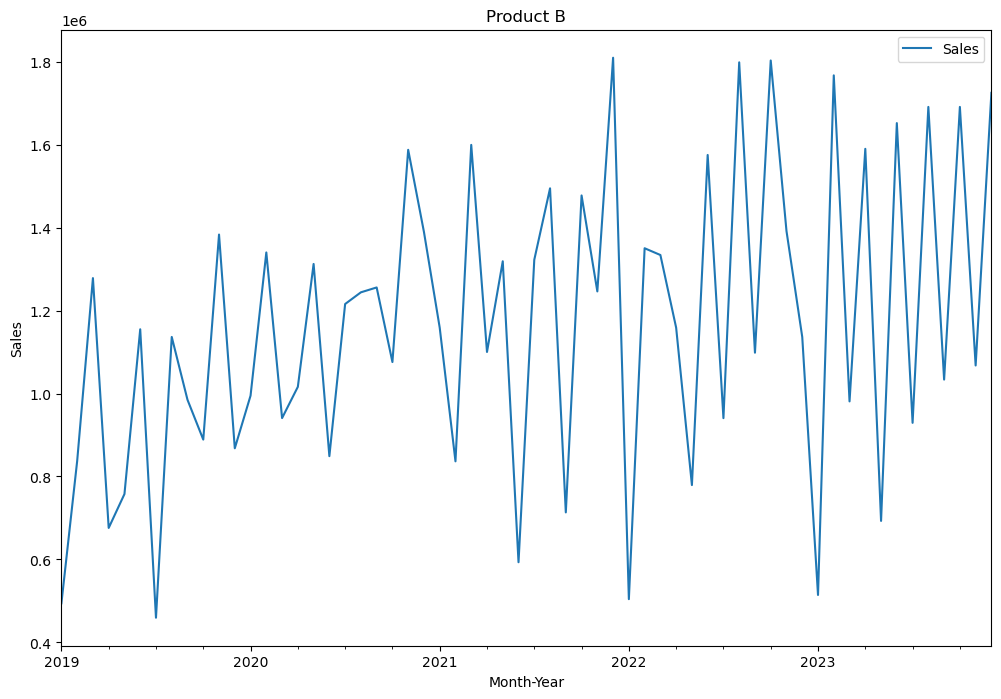

In [37]:
ax = sales_b.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product B')
plt.legend(['Sales'])
plt.show()


In [38]:
train= sales_b[:48]
test=sales_b[48:]

# Hyperparameter Tuning

In [39]:
changepoint_prior_scale_range = [0.001,0.01, 0.1, 0.1008, 0.2006, 0.3004, 0.4002, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 2.008, 4.006, 6.004, 8.002, 10.0]

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

17:02:42 - cmdstanpy - INFO - Chain [1] start processing
17:02:43 - cmdstanpy - INFO - Chain [1] done processing
17:02:45 - cmdstanpy - INFO - Chain [1] start processing
17:02:45 - cmdstanpy - INFO - Chain [1] done processing
17:02:48 - cmdstanpy - INFO - Chain [1] start processing
17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:52 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing
17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:58 - cmdstanpy - INFO - Chain [1] start processing
17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:02 - cmdstanpy - INFO - Chain [1] start processing
17:03:02 - cmdstanpy - INFO - Chain [1] done processing
17:03:04 - cmdstanpy - INFO - Chain [1] start processing
17:03:05 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing
17:03:08 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                    0.010  414230.850217
1                     0.001                    0.100  418866.217000
2                     0.001                    1.000  419198.104598
3                     0.001                    2.008  419141.178967
4                     0.001                    4.006  419270.283462
..                      ...                      ...            ...
59                    0.500                    2.008  463205.195198
60                    0.500                    4.006  540372.026129
61                    0.500                    6.004  426630.937861
62                    0.500                    8.002  392749.647395
63                    0.500                   10.000  366252.117295

[64 rows x 3 columns]


In [40]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,rmse
55,0.4002,10.000,167669.591712
34,0.2006,1.000,321087.746458
50,0.4002,1.000,327359.476495
42,0.3004,1.000,329238.139905
58,0.5000,1.000,337349.899047
...,...,...,...
33,0.2006,0.100,504236.681105
40,0.3004,0.010,517563.670225
60,0.5000,4.006,540372.026129
57,0.5000,0.100,564772.131228


In [42]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.4002, seasonality_prior_scale=10.000, interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

model = Prophet()
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [43]:
model.fit(train)

17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [45]:
future_dates['Market Size'] = sales_b['Market Size']
future_dates['Marketing Expense'] = sales_b['Marketing Expense']

In [46]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [47]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [48]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [49]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
48,2023-01-01,2.207368e+05,1.580163e+05,2.819120e+05
49,2023-02-01,1.352926e+06,1.289721e+06,1.418863e+06
50,2023-03-01,5.944475e+05,5.186656e+05,6.698715e+05
51,2023-04-01,1.142497e+06,1.049545e+06,1.243468e+06
52,2023-05-01,3.470101e+05,2.326144e+05,4.743114e+05
53,2023-06-01,1.180396e+06,1.031170e+06,1.338536e+06
54,2023-07-01,5.502340e+05,3.673930e+05,7.512772e+05
55,2023-08-01,1.197616e+06,9.903659e+05,1.438982e+06
56,2023-09-01,6.257740e+05,3.836853e+05,9.214793e+05
57,2023-10-01,1.181279e+06,8.940314e+05,1.508844e+06


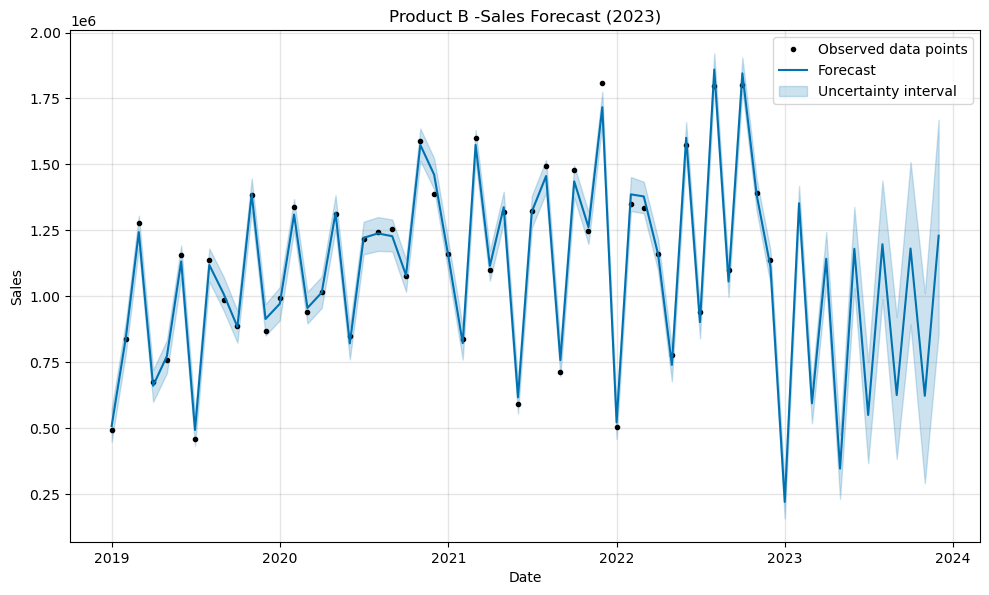

In [50]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product B -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

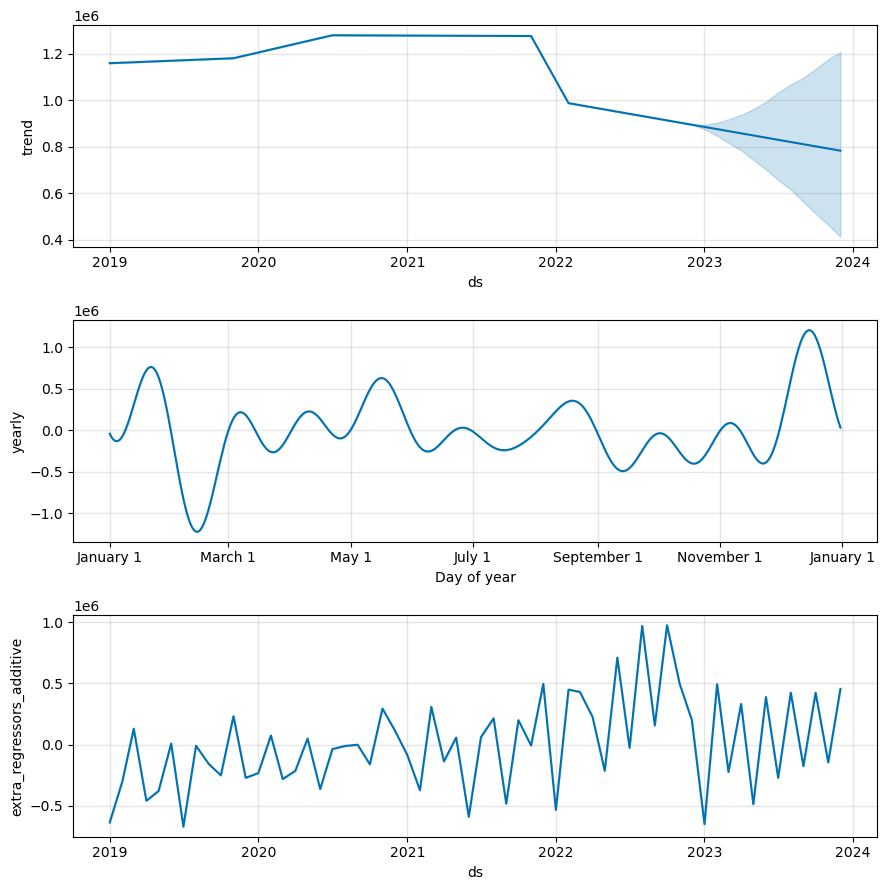

In [51]:
fig2 = model.plot_components(forecast)

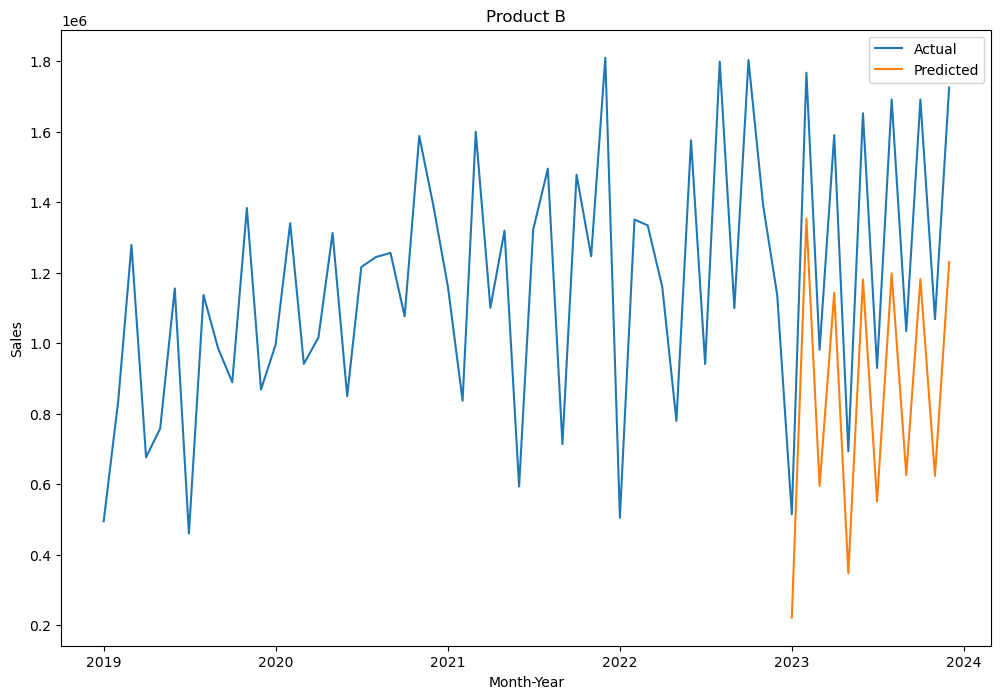

In [53]:
# Reset index of sales_b DataFrame
sales_b_reset_index = sales_b.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_b_reset_index['ds'], sales_b_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product B')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [54]:
#model evaluation

In [55]:
pred=forecasted_df['yhat']
test_df=test['y']

In [56]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 424090.646
MAPE - FB PROPHET: 0.364
MSE - FB PROPHET: 183797587322.993
RMSE - FB PROPHET: 428716.208


In [27]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [28]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [29]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,4.131610e+10,203263.612371,203263.612371,0.403074,0.403074,0.335466,0.0
1,62 days,1.991476e+11,446259.535969,446259.535969,0.330504,0.330504,0.283633,0.0
2,90 days,1.888879e+11,434612.346228,434612.346228,0.325811,0.325811,0.280170,0.0
3,121 days,1.647144e+11,405850.280004,405850.280004,0.350253,0.350253,0.298055,0.0
4,151 days,8.626916e+10,293716.114720,293716.114720,0.376889,0.376889,0.317128,0.0
5,182 days,2.614468e+11,511318.666408,511318.666408,0.324625,0.324625,0.279292,0.0
6,212 days,1.247572e+11,353209.835785,353209.835785,0.375496,0.375496,0.316141,0.0
7,243 days,3.384192e+11,581738.042732,581738.042732,0.323468,0.323468,0.278435,0.0
8,274 days,1.460089e+11,382111.159787,382111.159787,0.347867,0.347867,0.296326,0.0
9,304 days,3.538673e+11,594867.472985,594867.472985,0.329953,0.329953,0.283227,0.0


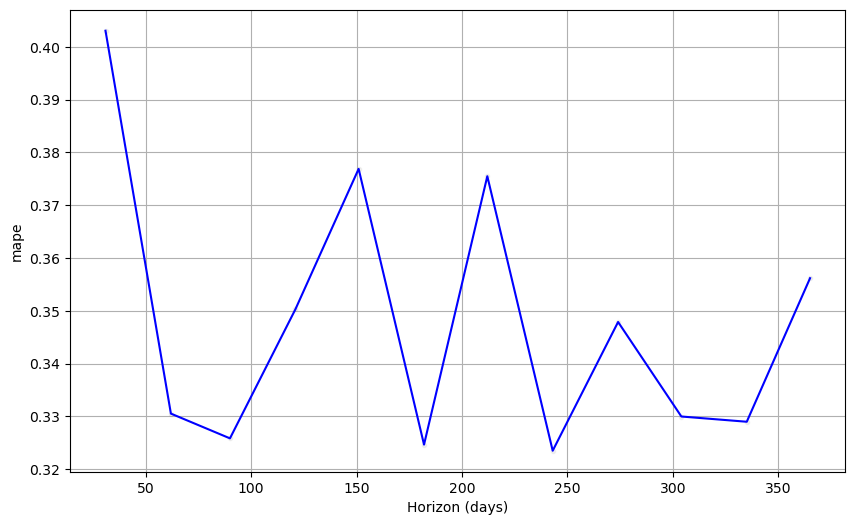

In [30]:
fig = plot_cross_validation_metric(df_cv, metric='mape')